In [ ]:
pip install datasets pandas tqdm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 3.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 10.4 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2025.3.2 requires fsspec==2025.3.2, but you have fsspec 2024.12.0 which is incompatible.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is 

In [ ]:
from datasets import load_dataset
import pandas as pd
from tqdm import tqdm

# Step 1: Load streaming dataset with the correct config name for reviews (e.g., 'raw_review_All_Beauty')
reviews_stream = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_review_All_Beauty", split="full", streaming=True)
metadata_stream = load_dataset("McAuley-Lab/Amazon-Reviews-2023", "raw_meta_All_Beauty", split="full", streaming=True)

# Step 2: Collect 50,000 filtered reviews
sampled_reviews = []
count = 0
MAX_REVIEWS = 50000

print("Collecting 50,000 reviews...")

for r in tqdm(reviews_stream):
    if r["text"] and r["verified_purchase"] and 1 <= r["rating"] <= 5:
        sampled_reviews.append({
            "review_title": r["title"],
            "review_text": r["text"],
            "rating": r["rating"],
            "verified": r["verified_purchase"],
            "asin": r["asin"],
            "user_id": r["user_id"],
            "timestamp": r["timestamp"],
            "helpful_vote": r["helpful_vote"],
            "parent_asin": r["parent_asin"]
        })
        count += 1
        if count >= MAX_REVIEWS:
            break

# Step 3: Optional — Create a dictionary of product metadata for faster lookup
print("Indexing metadata for joined info (title, category, features)...")
meta_dict = {}
for item in tqdm(metadata_stream):
    if item["parent_asin"] not in meta_dict:
        meta_dict[item["parent_asin"]] = {
            "product_title": item["title"],
            "main_category": item["main_category"],
            "features": item["features"],
            "description": item["description"],
            "categories": item["categories"]
        }

# Step 4: Join metadata to reviews
for r in sampled_reviews:
    meta = meta_dict.get(r["parent_asin"], {})
    r.update(meta)

# Step 5: Save to CSV
df = pd.DataFrame(sampled_reviews)
df.to_csv("amazon_reviews_50k.csv", index=False)

print("✅ Done! Saved 50K reviews to amazon_reviews_50k.csv")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/30.3k [00:00<?, ?B/s]

Amazon-Reviews-2023.py:   0%|          | 0.00/39.6k [00:00<?, ?B/s]

The repository for McAuley-Lab/Amazon-Reviews-2023 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/McAuley-Lab/Amazon-Reviews-2023.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


58022it [00:02, 20244.27it/s]


Indexing metadata for joined info (title, category, features)...


112590it [00:36, 3123.08it/s]


✅ Done! Saved 50K reviews to amazon_reviews_50k.csv


In [ ]:
print(df.info())
print(df.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   review_title   50000 non-null  object 
 1   review_text    50000 non-null  object 
 2   rating         50000 non-null  float64
 3   verified       50000 non-null  bool   
 4   asin           50000 non-null  object 
 5   user_id        50000 non-null  object 
 6   timestamp      50000 non-null  int64  
 7   helpful_vote   50000 non-null  int64  
 8   parent_asin    50000 non-null  object 
 9   product_title  50000 non-null  object 
 10  main_category  50000 non-null  object 
 11  features       50000 non-null  object 
 12  description    50000 non-null  object 
 13  categories     50000 non-null  object 
dtypes: bool(1), float64(1), int64(2), object(10)
memory usage: 5.0+ MB
None
                                review_title  \
0  Such a lovely scent but not overpowering.   
1     Works gr

In [ ]:
import nltk
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [ ]:
import re
import nltk
from nltk.corpus import stopwords

# Example text cleaning function
def clean_text(text):
    # Convert to lowercase
    text = text.lower()
    # Remove non-alphabetic characters
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    text = ' '.join([word for word in text.split() if word not in stop_words])
    return text

# Apply the cleaning function to review text
df['cleaned_review_text'] = df['review_text'].apply(clean_text)

In [ ]:
print(df['cleaned_review_text'].head())

0    spray really nice smells really good goes real...
1    product need wish odorless soft coconut smell ...
2                              smells good feels great
3                                       felt synthetic
4                                                 love
Name: cleaned_review_text, dtype: object


In [ ]:
!pip install --upgrade numpy gensim
!pip uninstall numpy gensim -y
!pip install numpy gensim


  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
Found existing installation: numpy 1.26.4
Uninstalling numpy-1.26.4:
  Successfully uninstalled numpy-1.26.4
Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached numpy-2.2.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (62 kB)
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
  Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (61 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)
Using cached numpy-1.26.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (18.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
th

In [ ]:
!python -m spacy download en_core_web_md


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 33.5/33.5 MB 34.0 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_md')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [ ]:
import spacy
import numpy as np

# Load the English NLP model for POS tagging and word embeddings
nlp = spacy.load('en_core_web_md')  # You can use 'en_core_web_lg' for better quality embeddings
# Function to extract aspects using POS tagging
def extract_aspects(text):
    doc = nlp(text)
    aspects = []
    # Extracting nouns and adjectives (aspects and sentiment words)
    for token in doc:
        if token.pos_ in ['NOUN', 'ADJ']:  # Nouns for aspects, adjectives for sentiment
            aspects.append(token.text)
    return aspects

# Apply aspect extraction to the cleaned review text
df['extracted_aspects'] = df['cleaned_review_text'].apply(extract_aspects)


# Function to get word embeddings for a text (average embeddings of words)
def get_word_embeddings(text):
    doc = nlp(text)
    embeddings = [token.vector for token in doc if token.has_vector]

    if embeddings:
        return np.mean(embeddings, axis=0)  # Average the word embeddings
    elif len(doc) > 0:
        return np.zeros(len(doc[0].vector))  # Safe: only access doc[0] if doc is not empty
    else:
        return np.zeros(nlp.vocab.vectors_length)  # General fallback if doc is empty
 # Return zero vector if no embeddings found, using the first token's vector size

# Apply word embeddings to each review text
df['word_embeddings'] = df['cleaned_review_text'].apply(get_word_embeddings)

In [ ]:
print(df['word_embeddings'].head())
print(df['extracted_aspects'].head())

0    [-0.7308807, 0.15980159, -0.1874152, -0.144591...
1    [-0.700781, 0.028206851, -0.053949498, 0.00195...
2    [-0.7421725, 0.056207497, -0.25395, 0.04439125...
3    [-0.684265, -0.2719425, -0.100155, -0.30135, -...
4    [-0.61052, 0.11656, -0.50648, -0.32216, -0.099...
Name: word_embeddings, dtype: object
0    [nice, good, fine, trick, lot, texture, lot, h...
1    [product, odorless, soft, coconut, smell, head...
2                                        [good, great]
3                                          [synthetic]
4                                               [love]
Name: extracted_aspects, dtype: object


In [ ]:
print(df['cleaned_review_text'].head())


0    spray really nice smells really good goes real...
1    product need wish odorless soft coconut smell ...
2                              smells good feels great
3                                       felt synthetic
4                                                 love
Name: cleaned_review_text, dtype: object


In [ ]:
def assign_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

df['sentiment'] = df['rating'].apply(assign_sentiment)


In [ ]:
print(df['sentiment'].head())

0    positive
1    positive
2    positive
3    negative
4    positive
Name: sentiment, dtype: object


In [ ]:
from collections import Counter

# Function to count aspect frequencies in each review
def count_aspects(aspects):
    return dict(Counter(aspects))

# Apply the aspect count function to the extracted aspects
df['aspect_counts'] = df['extracted_aspects'].apply(count_aspects)
print(df['aspect_counts'].head())


0    {'nice': 1, 'good': 1, 'fine': 1, 'trick': 1, ...
1    {'product': 1, 'odorless': 1, 'soft': 1, 'coco...
2                              {'good': 1, 'great': 1}
3                                     {'synthetic': 1}
4                                          {'love': 1}
Name: aspect_counts, dtype: object


In [ ]:
# Adding review length feature (in terms of number of words)
df['review_length'] = df['cleaned_review_text'].apply(lambda x: len(x.split()))

# Adding character length feature (total characters in review text)
df['review_char_length'] = df['cleaned_review_text'].apply(len)

print(df[['review_length', 'review_char_length']].head())


   review_length  review_char_length
0             31                 185
1             20                 134
2              4                  23
3              2                  14
4              1                   4


In [ ]:
import nltk
nltk.download('vader_lexicon')


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...


True

In [ ]:
from nltk.sentiment import SentimentIntensityAnalyzer

# Initialize VADER Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Function to extract sentiment score
def sentiment_score(text):
    return sia.polarity_scores(text)['compound']

# Add sentiment score feature
df['sentiment_score'] = df['cleaned_review_text'].apply(sentiment_score)
print(df['sentiment_score'].head())

# Function to assign sentiment score to all aspects
def aspect_sentiment(aspects, sentiment):
    return [(aspect, sentiment) for aspect in aspects]

# Modify to ensure that sentiment is assigned uniformly to each aspect for the given review
df['aspect_sentiment'] = df.apply(lambda row: aspect_sentiment(row['extracted_aspects'], row['sentiment_score']), axis=1)

print(df['aspect_sentiment'].head())


0    0.7846
1    0.8402
2    0.7906
3    0.0000
4    0.6369
Name: sentiment_score, dtype: float64
0    [(nice, 0.7846), (good, 0.7846), (fine, 0.7846...
1    [(product, 0.8402), (odorless, 0.8402), (soft,...
2                    [(good, 0.7906), (great, 0.7906)]
3                                   [(synthetic, 0.0)]
4                                     [(love, 0.6369)]
Name: aspect_sentiment, dtype: object


In [ ]:
import spacy
from collections import defaultdict

nlp = spacy.load("en_core_web_md")

reviews = [
    "The battery life is great, but the camera quality is poor.",
    "The camera is fantastic and the battery life lasts all day!",
    "The product is terrible. The screen is fine, but the performance is awful.",
    "The sound quality is amazing, but the design is cheap."
]

def extract_aspects_with_sentiment(text):
    doc = nlp(text)
    aspects_sentiments = defaultdict(list)

    for token in doc:
        # If the token is an adjective, we try to find what noun it modifies
        if token.pos_ == 'ADJ':
            # Look for the noun that this adjective modifies
            for head in token.head.subtree:
                if head.pos_ == 'NOUN':
                    # Reconstruct compound noun (aspect)
                    compound_parts = [child.text for child in head.children if child.dep_ == "compound"]
                    compound_parts.append(head.text)
                    aspect = " ".join(compound_parts)
                    aspects_sentiments[aspect].append(token.text)
                    break

    return aspects_sentiments

# Run the function on each review
for review in reviews:
    print(f"\nReview: {review}")
    aspects_sentiments = extract_aspects_with_sentiment(review)
    for aspect, sentiments in aspects_sentiments.items():
        print(f"  Aspect: {aspect}, Sentiment(s): {', '.join(sentiments)}")


Review: The battery life is great, but the camera quality is poor.
  Aspect: battery, Sentiment(s): great
  Aspect: camera, Sentiment(s): poor

Review: The camera is fantastic and the battery life lasts all day!
  Aspect: camera, Sentiment(s): fantastic

Review: The product is terrible. The screen is fine, but the performance is awful.
  Aspect: product, Sentiment(s): terrible
  Aspect: screen, Sentiment(s): fine
  Aspect: performance, Sentiment(s): awful

Review: The sound quality is amazing, but the design is cheap.
  Aspect: quality, Sentiment(s): sound, amazing
  Aspect: design, Sentiment(s): cheap


In [ ]:
df['aspect_sentiments'] = df['review_text'].apply(extract_aspects_with_sentiment)
print(df['aspect_sentiments'].head())

0    {'spray': ['nice'], 'trick': ['good'], 'thickn...
1    {'coconut': ['odorless', 'soft'], 'coffee': ['...
2                                                   {}
3                                                   {}
4                                                   {}
Name: aspect_sentiments, dtype: object


In [ ]:
print(df['aspect_sentiments'])

0        {'spray': ['nice'], 'trick': ['good'], 'thickn...
1        {'coconut': ['odorless', 'soft'], 'coffee': ['...
2                                                       {}
3                                                       {}
4                                                       {}
                               ...                        
49995    {'brush': ['Great', 'less'], 'brushing': ['qui...
49996                                  {'times': ['dead']}
49997                                                   {}
49998                                                   {}
49999    {'color': ['perfect'], 'mushroom': ['little', ...
Name: aspect_sentiments, Length: 50000, dtype: object


In [ ]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def normalize_aspect_sentiments(aspect_dict):
    normalized = {}
    for aspect, sentiments in aspect_dict.items():
        root = lemmatizer.lemmatize(aspect.lower())
        if root in normalized:
            normalized[root] += sentiments
        else:
            normalized[root] = sentiments
    return normalized

df['aspect_sentiments'] = df['aspect_sentiments'].apply(normalize_aspect_sentiments)

In [ ]:
print(df['aspect_sentiments'].head())

0    {'spray': ['nice'], 'trick': ['good'], 'thickn...
1    {'coconut': ['odorless', 'soft'], 'coffee': ['...
2                                                   {}
3                                                   {}
4                                                   {}
Name: aspect_sentiments, dtype: object


In [ ]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sia = SentimentIntensityAnalyzer()

def score_sentiments(aspect_dict):
    aspect_scores = {}
    for aspect, sentiments in aspect_dict.items():
        combined = " ".join(sentiments)
        polarity = sia.polarity_scores(combined)['compound']
        aspect_scores[aspect] = polarity
    return aspect_scores

df['aspect_sentiment_scores'] = df['aspect_sentiments'].apply(score_sentiments)

In [ ]:
print(df['aspect_sentiment_scores'].head())

0    {'spray': 0.4215, 'trick': 0.4404, 'thickness'...
1                      {'coconut': 0.0, 'coffee': 0.0}
2                                                   {}
3                                                   {}
4                                                   {}
Name: aspect_sentiment_scores, dtype: object


In [ ]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 19 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   review_title             50000 non-null  object 
 1   review_text              50000 non-null  object 
 2   rating                   50000 non-null  float64
 3   verified                 50000 non-null  bool   
 4   asin                     50000 non-null  object 
 5   user_id                  50000 non-null  object 
 6   timestamp                50000 non-null  int64  
 7   helpful_vote             50000 non-null  int64  
 8   parent_asin              50000 non-null  object 
 9   product_title            50000 non-null  object 
 10  main_category            50000 non-null  object 
 11  features                 50000 non-null  object 
 12  description              50000 non-null  object 
 13  categories               50000 non-null  object 
 14  cleaned_review_text   

In [ ]:
import numpy as np

# Assuming 'word_embeddings' are in a format like list of arrays or strings
# We need to convert them to numerical vectors (e.g., by converting list of strings to numpy arrays)

def convert_embeddings_to_vectors(embedding_list):
    try:
        # Converting string representation to actual array of floats
        return np.array([float(i) for i in embedding_list[1:-1].split(',')])  # assuming the embedding is in a string format like "[0.1, 0.2, 0.3]"
    except:
        return np.zeros(300)  # Return a zero vector in case of error (e.g., empty or malformed embeddings)

df['embedding_vectors'] = df['word_embeddings'].apply(convert_embeddings_to_vectors)

# Check the shape of the embedding vectors
print(df['embedding_vectors'].head())

0    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
1    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
2    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
3    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
4    [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...
Name: embedding_vectors, dtype: object


In [ ]:
from collections import Counter

def extract_aspect_sentiment_features(aspect_sentiments):
    sentiment_features = Counter()
    for aspect, sentiments in aspect_sentiments.items():
        # Counting occurrences of positive/negative words
        sentiment_features[aspect] = len(sentiments)  # You could refine this further to count specific sentiment words
    return sentiment_features

df['aspect_sentiment_features'] = df['aspect_sentiments'].apply(extract_aspect_sentiment_features)

# Convert sentiment features to usable format (e.g., flatten to a vector)
aspect_features = pd.json_normalize(df['aspect_sentiment_features'])
df = pd.concat([df, aspect_features], axis=1)

# Check the result
print(df[['aspect_sentiment_features']].head())

                           aspect_sentiment_features
0  {'spray': 1, 'trick': 1, 'thickness': 1, 'bran...
1                        {'coconut': 2, 'coffee': 1}
2                                                 {}
3                                                 {}
4                                                 {}


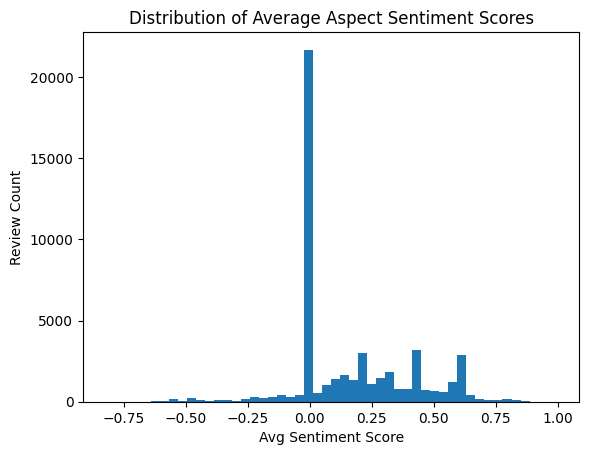

In [ ]:
import matplotlib.pyplot as plt
df['avg_score'] = df['aspect_sentiment_scores'].apply(lambda d: sum(d.values())/len(d) if isinstance(d, dict) and len(d) > 0 else 0)
plt.hist(df['avg_score'], bins=50)
plt.title("Distribution of Average Aspect Sentiment Scores")
plt.xlabel("Avg Sentiment Score")
plt.ylabel("Review Count")
plt.show()


In [ ]:
import ast

def get_sentiment_label_combined(score_dict, rating):
    if not score_dict or len(score_dict) == 0:
        avg_score = 0
    else:
        avg_score = sum(score_dict.values()) / len(score_dict)

    # Combine sentiment score + rating
    if avg_score > 0.05:
        sentiment = 'positive'
    elif avg_score < -0.05:
        sentiment = 'negative'
    else:
        sentiment = 'neutral'

    # Adjust based on rating
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return sentiment
    elif rating >= 4:
        if sentiment == 'negative':
            return 'neutral'
        return 'positive'
    else:
        return sentiment

# Convert stringified dicts to actual dicts if needed
df['aspect_sentiment_scores'] = df['aspect_sentiment_scores'].apply(
    lambda x: ast.literal_eval(x) if isinstance(x, str) else x
)

# ✅ Apply the new combined logic with both aspect sentiment + rating
df['label'] = df.apply(
    lambda row: get_sentiment_label_combined(row['aspect_sentiment_scores'], row['rating']),
    axis=1
)

# Check output
print(df.head())
print(df['label'].value_counts())
print(df['label'].head())
print(df['review_text'].head())

NameError: name 'df' is not defined

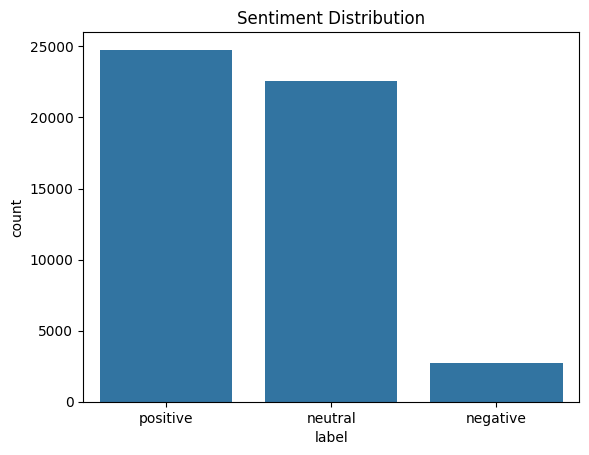

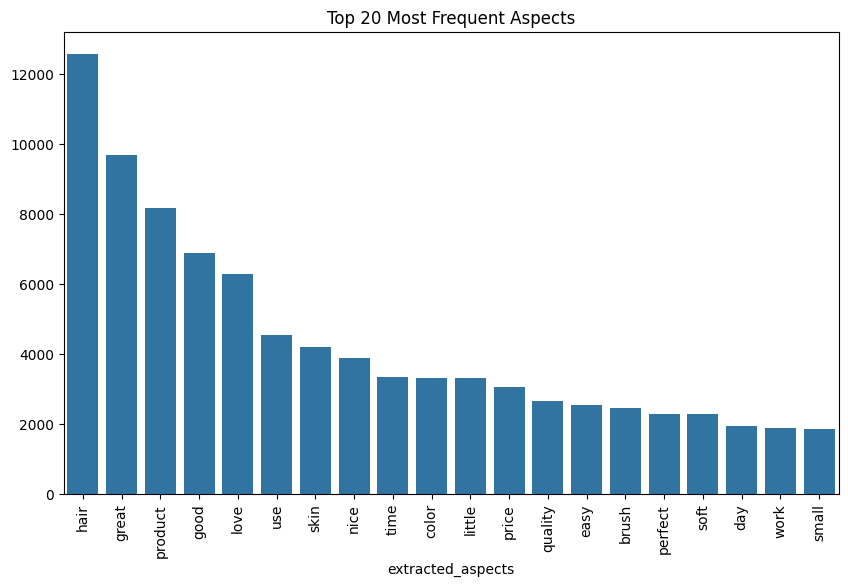

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Visualizing sentiment distribution
sns.countplot(data=df, x='label')
plt.title('Sentiment Distribution')
plt.show()

# Aspect frequency visualization
aspect_frequency = df['extracted_aspects'].explode().value_counts().head(20)
plt.figure(figsize=(10, 6))
sns.barplot(x=aspect_frequency.index, y=aspect_frequency.values)
plt.title('Top 20 Most Frequent Aspects')
plt.xticks(rotation=90)
plt.show()

In [ ]:
# Train-test split for classification
from sklearn.model_selection import train_test_split
X = df['cleaned_review_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorize text data using TF-IDF
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_test_tfidf = vectorizer.transform(X_test)

# Train a Logistic Regression model
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

model = LogisticRegression(class_weight='balanced')
model.fit(X_train_tfidf, y_train)

# Evaluate the model
y_pred = model.predict(X_test_tfidf)
print(f'Accuracy: {accuracy_score(y_test, y_pred)}')

Accuracy: 0.7371


/usr/local/lib/python3.11/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[[ 434   72   60]
 [ 388 3245  949]
 [ 203  957 3692]]


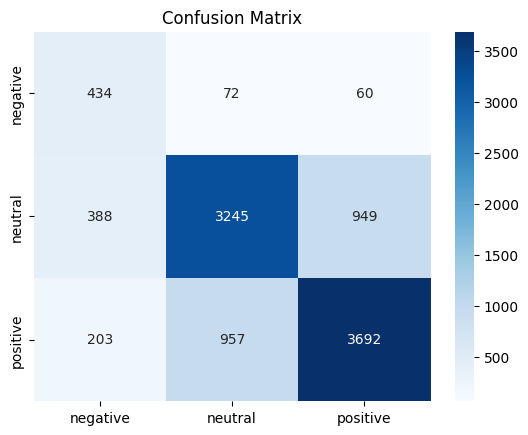

              precision    recall  f1-score   support

    negative       0.42      0.77      0.55       566
     neutral       0.76      0.71      0.73      4582
    positive       0.79      0.76      0.77      4852

    accuracy                           0.74     10000
   macro avg       0.66      0.75      0.68     10000
weighted avg       0.75      0.74      0.74     10000



In [ ]:
from sklearn.metrics import confusion_matrix,classification_report
import seaborn as sns

conf_matrix = confusion_matrix(y_test, y_pred)
print(conf_matrix)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.show()
print(classification_report(y_test, y_pred, target_names=['negative', 'neutral', 'positive']))

In [ ]:
pip install torch torchvision scikit-learn pandas numpy


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 28.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 379.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 914.4 kB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 1.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 43.0 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitl

In [ ]:
print(df.info())
print(df.columns)
print(df['sentiment'])

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Columns: 7413 entries, review_title to yorkie mix
dtypes: bool(1), float64(7388), int64(4), object(20)
memory usage: 2.8+ GB
None
Index(['review_title', 'review_text', 'rating', 'verified', 'asin', 'user_id',
       'timestamp', 'helpful_vote', 'parent_asin', 'product_title',
       ...
       'gk products', 'record', 'carving', 'glitch', 'matting', 'feet.<br',
       'infusium', 'employee', 'cigarette', 'yorkie mix'],
      dtype='object', length=7413)
0        positive
1        positive
2        positive
3        negative
4        positive
           ...   
49995    positive
49996    negative
49997    positive
49998    positive
49999    positive
Name: sentiment, Length: 50000, dtype: object


In [ ]:
print(df['aspect_sentiment_scores'])

0        {'spray': 0.4215, 'trick': 0.4404, 'thickness'...
1                          {'coconut': 0.0, 'coffee': 0.0}
2                                                       {}
3                                                       {}
4                                                       {}
                               ...                        
49995    {'brush': 0.6249, 'brushing': 0.0, 'mat': 0.51...
49996                                    {'time': -0.6486}
49997                                                   {}
49998                                                   {}
49999    {'color': 0.5719, 'mushroom': 0.3832, 'coverag...
Name: aspect_sentiment_scores, Length: 50000, dtype: object


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Step 1: Tokenize the cleaned review text
tokenizer = Tokenizer(oov_token="<OOV>")
tokenizer.fit_on_texts(df['cleaned_review_text'])

# Step 2: Convert text to sequences
sequences = tokenizer.texts_to_sequences(df['cleaned_review_text'])

# Step 3: Pad sequences to the same length
max_len = 100  # or dynamically: max_len = max(len(x) for x in sequences)
padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

# Now padded_sequences can be used as X_train or input for your DL model


In [ ]:
print(df['word_embeddings'].head())


0    [-0.7308807, 0.15980159, -0.1874152, -0.144591...
1    [-0.700781, 0.028206851, -0.053949498, 0.00195...
2    [-0.7421725, 0.056207497, -0.25395, 0.04439125...
3    [-0.684265, -0.2719425, -0.100155, -0.30135, -...
4    [-0.61052, 0.11656, -0.50648, -0.32216, -0.099...
Name: word_embeddings, dtype: object


['negative' 'neutral' 'positive']


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 163s 255ms/step - accuracy: 0.2588 - loss: 1.1090 - val_accuracy: 0.4641 - val_loss: 1.0913
Epoch 2/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 152s 243ms/step - accuracy: 0.3508 - loss: 1.1022 - val_accuracy: 0.4651 - val_loss: 1.0674
Epoch 3/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 252ms/step - accuracy: 0.3648 - loss: 1.0887 - val_accuracy: 0.0636 - val_loss: 1.1043
Epoch 4/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 157s 252ms/step - accuracy: 0.3052 - loss: 1.0947 - val_accuracy: 0.4852 - val_loss: 1.0926
Epoch 5/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 196s 242ms/step - accuracy: 0.3054 - loss: 1.1007 - val_accuracy: 0.0638 - val_loss: 1.1029
Epoch 6/6
625/625 ━━━━━━━━━━━━━━━━━━━━ 207s 251ms/step - accuracy: 0.1910 - loss: 1.1076 - val_accuracy: 0.6149 - val_loss: 1.0420
313/313 ━━━━━━━━━━━━━━━━━━━━ 18s 56ms/step
Accuracy: 0.6149


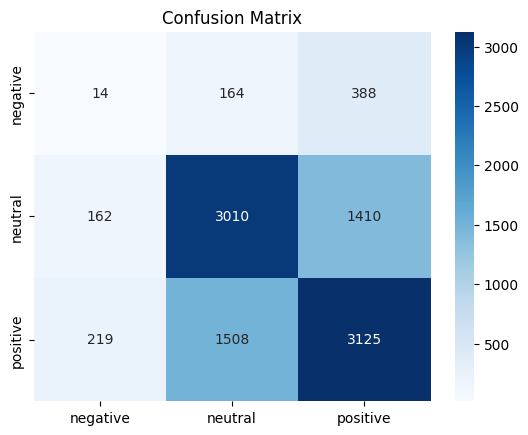

              precision    recall  f1-score   support

    negative       0.04      0.02      0.03       566
     neutral       0.64      0.66      0.65      4582
    positive       0.63      0.64      0.64      4852

    accuracy                           0.61     10000
   macro avg       0.44      0.44      0.44     10000
weighted avg       0.60      0.61      0.61     10000



In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)  # Using top 5000 words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to make sure each review has the same length
max_sequence_length = 100  # You can adjust this length based on your dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Step 2: Label Encoding for y_train and y_test (if your labels are strings)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Verify the encoding
print(label_encoder.classes_)  # Check how the labels were mapped

# Step 3: Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_sequence_length))  # Embedding layer
model.add(LSTM(128, return_sequences=False))  # LSTM layer with 128 units
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes (positive, neutral, negative)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])

# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train_encoded), y=y_train_encoded)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
history = model.fit(X_train_pad, y_train_encoded, epochs=6, batch_size=64, validation_data=(X_test_pad, y_test_encoded), class_weight=class_weights)

# Step 5: Evaluate the model on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=-1)  # Convert predicted probabilities to class labels

# Step 6: Evaluate performance
print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred_classes)}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test_encoded, y_pred_classes, target_names=['negative', 'neutral', 'positive']))


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
import numpy as np

# Step 1: Tokenization and Padding
tokenizer = Tokenizer(num_words=5000)  # Using top 5000 words
tokenizer.fit_on_texts(X_train)

# Convert text to sequences
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

# Pad sequences to make sure each review has the same length
max_sequence_length = 100  # You can adjust this length based on your dataset
X_train_pad = pad_sequences(X_train_seq, maxlen=max_sequence_length, padding='post', truncating='post')
X_test_pad = pad_sequences(X_test_seq, maxlen=max_sequence_length, padding='post', truncating='post')

# Step 2: Label Encoding for y_train and y_test (if your labels are strings)
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Verify the encoding
print(label_encoder.classes_)  # Check how the labels were mapped

# Step 3: Build the LSTM model
model = Sequential()
model.add(Embedding(input_dim=5000, output_dim=100, input_length=max_sequence_length))  # Embedding layer
model.add(LSTM(128, return_sequences=False))  # LSTM layer with 128 units
model.add(Dropout(0.2))  # Dropout for regularization
model.add(Dense(3, activation='softmax'))  # Output layer for 3 classes (positive, neutral, negative)

# Compile the model
model.compile(loss='sparse_categorical_crossentropy', optimizer=Adam(), metrics=['accuracy'])


# Compute class weights based on the training labels
class_weights = compute_class_weight('balanced', classes=np.unique(y_train), y=y_train)
class_weights = {i: class_weights[i] for i in range(len(class_weights))}

# Train the model with class weights
history = model.fit(X_train_pad, y_train, epochs=6, batch_size=64, validation_data=(X_test_pad, y_test), class_weight=class_weights)


# Step 5: Evaluate the model on the test set
y_pred = model.predict(X_test_pad)
y_pred_classes = y_pred.argmax(axis=-1)  # Convert predicted probabilities to class labels

# Step 6: Evaluate performance
print(f'Accuracy: {accuracy_score(y_test_encoded, y_pred_classes)}')

# Confusion Matrix
conf_matrix = confusion_matrix(y_test_encoded, y_pred_classes)
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["negative", "neutral", "positive"], yticklabels=["negative", "neutral", "positive"])
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_test_encoded, y_pred_classes, target_names=['negative', 'neutral', 'positive']))

In [ ]:
!pip install transformers datasets


In [ ]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from datasets import Dataset
import torch
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments


In [ ]:
# Train-test split for classification
from sklearn.model_selection import train_test_split
X = df['cleaned_review_text']
y = df['label']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [ ]:
# Encode the labels
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

# Convert to Hugging Face Dataset format
train_df = pd.DataFrame({'text': X_train, 'label': y_train_encoded})
test_df = pd.DataFrame({'text': X_test, 'label': y_test_encoded})

train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)


In [ ]:
tokenizer = BertTokenizer.from_pretrained("bert-base-uncased")

def tokenize_function(examples):
    return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=100)

train_dataset = train_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

# Set format for PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Map:   0%|          | 0/40000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [ ]:
model = BertForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=3)


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

from transformers import TrainingArguments

training_args = TrainingArguments(
    output_dir="./results",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=64,
    num_train_epochs=3,
    eval_strategy="epoch",
    save_strategy="epoch",
    logging_dir="./logs",
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    report_to="none",  # No wandb, no TensorBoard, etc.
)


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    return {"accuracy": acc}

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()


Epoch,Training Loss,Validation Loss,Accuracy
1,0.356000,0.339487,0.856900
2,0.284300,0.322069,0.870200
3,0.219400,0.393540,0.870800


TrainOutput(global_step=7500, training_loss=0.30492476704915367, metrics={'train_runtime': 2391.7508, 'train_samples_per_second': 50.172, 'train_steps_per_second': 3.136, 'total_flos': 6166720728000000.0, 'train_loss': 0.30492476704915367, 'epoch': 3.0})

In [ ]:
predictions = trainer.predict(test_dataset)
y_pred = np.argmax(predictions.predictions, axis=1)

print("Classification Report:\n")
print(classification_report(y_test_encoded, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:\n")
print(confusion_matrix(y_test_encoded, y_pred))


Classification Report:

              precision    recall  f1-score   support

    negative       0.70      0.70      0.70       566
     neutral       0.89      0.83      0.86      4582
    positive       0.88      0.93      0.90      4852

    accuracy                           0.87     10000
   macro avg       0.82      0.82      0.82     10000
weighted avg       0.87      0.87      0.87     10000

Confusion Matrix:

[[ 396  137   33]
 [ 156 3817  609]
 [  14  343 4495]]


In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification
import torch

# Load the trained model (use your actual path if saved)
model_path = "./results"  # or wherever you saved it
tokenizer = BertTokenizer.from_pretrained(model_path)
model = BertForSequenceClassification.from_pretrained(model_path)

# Ensure model is in eval mode
model.eval()


In [ ]:
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding=True)
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        predicted_class = torch.argmax(logits, dim=1).item()

    label_map = {
        0: "negative",
        1: "neutral",
        2: "positive"
    }

    return label_map[predicted_class]


In [ ]:
sample_text = "I really love this product, it exceeded all my expectations!"
print("Sentiment:", predict_sentiment(sample_text))

sample_text2 = "It's okay, not the best but not terrible either."
print("Sentiment:", predict_sentiment(sample_text2))

sample_text3 = "I'm extremely disappointed and angry about this experience."
print("Sentiment:", predict_sentiment(sample_text3))
